# Task 1

In [1]:
!pip install ucimlrepo

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
auto_mpg = fetch_ucirepo(id=9)

# data (as pandas dataframes)
X = auto_mpg.data.features
y = auto_mpg.data.targets

# metadata
print(auto_mpg.metadata)

# variable information
print(auto_mpg.variables)


{'uci_id': 9, 'name': 'Auto MPG', 'repository_url': 'https://archive.ics.uci.edu/dataset/9/auto+mpg', 'data_url': 'https://archive.ics.uci.edu/static/public/9/data.csv', 'abstract': 'Revised from CMU StatLib library, data concerns city-cycle fuel consumption', 'area': 'Other', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 398, 'num_features': 7, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': [], 'target_col': ['mpg'], 'index_col': ['car_name'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1993, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5859H', 'creators': ['R. Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is a slightly modified version of the dataset provided in the StatLib library.  In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for th

In [4]:
X.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1


In [5]:
y.head()

,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0


#Task - 2

In [6]:
import pandas as pd

df = pd.concat([X, y], axis=1)
df.isnull().sum()

,0
displacement,0
cylinders,0
horsepower,6
weight,0
acceleration,0
model_year,0
origin,0
mpg,0


In [7]:
df = df.dropna()
len(df)

392

In [8]:
x_cleaned = df.iloc[:, :-1]
y_cleaned = df.iloc[:, -1]
x_cleaned = x_cleaned.reset_index(drop=True)
y_cleaned = y_cleaned.reset_index(drop=True)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_cleaned)
#y_scaled = y_cleaned.fit_transform(y_cleaned)


In [25]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets (75% training, 25% test)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#Task - 3

In [73]:
import numpy as np

class TreeBranch:
    def __init__(self, attribute_idx=None, split_value=None, left_child=None, right_child=None, variance_decrease=None, prediction=None):
        # We make the TreeBranch with given parameters or default to None
        self.attribute_idx = attribute_idx
        self.split_value = split_value
        self.left_child = left_child
        self.right_child = right_child
        self.variance_decrease = variance_decrease
        self.prediction = prediction

class RegressionTreeModel:
    def __init__(self, min_samples_for_split=2, max_tree_depth=2):
        # We begin with the tree's root, minimum samples for a split, and maximum depth
        self.tree_root = None
        self.min_samples_for_split = min_samples_for_split
        self.max_tree_depth = max_tree_depth

    def grow_tree(self, data, current_depth=0):
        # extracting features and target variable from the dataset
        features, target = data[:, :-1], data[:, -1]
        sample_count, feature_count = features.shape
        optimal_split = {}          # dictionary for tracking optimal_split

        # We check if we can split further based on sample count and tree depth
        if sample_count >= self.min_samples_for_split and current_depth <= self.max_tree_depth:
            optimal_split = self.find_optimal_split(data, sample_count, feature_count)
            # proceed with the split if there is a positive variance decrease
            if optimal_split["variance_decrease"] > 0:
                left_subtree = self.grow_tree(optimal_split["left_subset"], current_depth + 1)
                right_subtree = self.grow_tree(optimal_split["right_subset"], current_depth + 1)

                # We return a branch node with details of the split and its children
                return TreeBranch(optimal_split["attribute_idx"], optimal_split["split_value"],
                                  left_subtree, right_subtree, optimal_split["variance_decrease"])

        # creating a leaf node with the average target value when no further split is possible
        leaf_prediction = self.compute_leaf_prediction(target)
        return TreeBranch(prediction=leaf_prediction)

    def find_optimal_split(self, data, sample_count, feature_count):
        optimal_split = {}
        max_variance_decrease = float("-inf")

        # We iterate over each feature to determine the best split point
        for attribute_idx in range(feature_count):
            attribute_values = data[:, attribute_idx]
            unique_values = np.unique(attribute_values)

            # We test each unique value of the feature as a potential split point
            for split_value in unique_values:
                left_subset, right_subset = self.partition_data(data, attribute_idx, split_value)

                # We only consider valid splits where both subsets have data
                if len(left_subset) > 0 and len(right_subset) > 0:
                    y, left_y, right_y = data[:, -1], left_subset[:, -1], right_subset[:, -1]
                    current_variance_decrease = self.calculate_MSE(y, left_y, right_y)

                    # We keep track of the split that maximizes variance decrease
                    if current_variance_decrease > max_variance_decrease:
                        optimal_split = {
                            "attribute_idx": attribute_idx,
                            "split_value": split_value,
                            "left_subset": left_subset,
                            "right_subset": right_subset,
                            "variance_decrease": current_variance_decrease
                        }
                        max_variance_decrease = current_variance_decrease

        # We return the best split found
        return optimal_split

    def partition_data(self, data, attribute_idx, split_value):
        # We split the data based on whether the feature value is less than or equal to the split value
        left_mask = data[:, attribute_idx] <= split_value
        return data[left_mask], data[~left_mask]

    def calculate_MSE(self, parent, left_child, right_child):
        # We compute the MSE as the criterion for the split
        parent_mse = np.mean((parent - np.mean(parent)) ** 2)
        left_child_mse = np.mean((left_child - np.mean(left_child)) ** 2)
        right_child_mse = np.mean((right_child - np.mean(right_child)) ** 2)

        w_left = len(left_child) / len(parent)
        w_right = len(right_child) / len(parent)
        decrease = parent_mse - (w_left * left_child_mse + w_right * right_child_mse)
        return decrease

    def compute_leaf_prediction(self, target):
        # We return the mean of the target values for leaf prediction
        return np.mean(target)

    def display_tree(self, node=None, indent=""):
        # We display the tree structure in a human-readable format
        if not node:
            node = self.tree_root

        if node.prediction is not None:
            # We print the prediction if it's a leaf node
            print(node.prediction)
        else:
            # We print the details of the split at the branch node
            print(f"X_{node.attribute_idx} <= {node.split_value} ? {node.variance_decrease}")
            print(f"{indent}left:", end="")
            # We recursively display the left subtree
            self.display_tree(node.left_child, indent + indent)
            print(f"{indent}right:", end="")
            # We recursively display the right subtree
            self.display_tree(node.right_child, indent + indent)

    def train(self, X, y):
        # We combine features and target into a single dataset and start growing the tree
        data = np.column_stack((X, y))
        self.tree_root = self.grow_tree(data)

    def predict_sample(self, sample, node):
        # We recursively traverse the tree to make a prediction for a single sample
        if node.prediction is not None:
            # We return the prediction if it's a leaf node
            return node.prediction

        # We decide which branch to follow based on the split value
        if sample[node.attribute_idx] <= node.split_value:
            return self.predict_sample(sample, node.left_child)
        else:
            return self.predict_sample(sample, node.right_child)

    def predict(self, X):
        # We convert Pandas DataFrame to NumPy array if necessary and predict for each sample
        X = X.values  # Convert Pandas DataFrame to NumPy array
        return [self.predict_sample(sample, self.tree_root) for sample in X]


In [74]:
# call a object of RegressionTreeModel class
tree_model = RegressionTreeModel(min_samples_for_split=3, max_tree_depth=3)
tree_model.train(x_train, y_train) # call model.train() to train the model

# Display the tree structure
tree_model.display_tree()

X_0 <= 183.0 ? 36.25060072953911
left:X_2 <= 76.0 ? 12.375308691856844
left:X_5 <= 77.0 ? 9.509837351550132
left:X_3 <= 2074.0 ? 5.264208984374999
left:30.5
right:25.55
right:X_0 <= 91.0 ? 4.901598840760792
left:37.520833333333336
right:33.092
right:X_5 <= 78.0 ? 8.153520988288157
left:X_3 <= 2755.0 ? 3.7193431296039803
left:24.447916666666668
right:19.73846153846154
right:X_3 <= 2556.0 ? 8.165339664951855
left:33.05714285714286
right:27.133333333333336
right:X_2 <= 125.0 ? 5.817302983566876
left:X_5 <= 81.0 ? 5.601926259153601
left:X_5 <= 75.0 ? 1.4986498439125908
left:17.838709677419356
right:20.287096774193547
right:38.0
right:X_5 <= 76.0 ? 1.716907035781544
left:X_3 <= 4215.0 ? 0.7195579988535523
left:14.64516129032258
right:12.946428571428571
right:X_3 <= 3880.0 ? 1.4137524801587302
left:18.38571428571429
right:15.988888888888889


In [69]:
# Make predictions using the trained model
predictions = tree_model.predict(x_test)

# Import mean_squared_error from sklearn.metrics
from sklearn.metrics import mean_squared_error

# Calculate and print the mean squared error
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 11.759610061572289


# Task - 4

In [ ]:
# we have to perform K-fold cross-validation and tune two hyperparameters
# 1. max_depth
# 2. min_samples in leaf

In [70]:
from sklearn.model_selection import KFold
max_depth_values = [3, 4, 5, 6]
min_samples_leaf_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

folds = KFold(n_splits=5, shuffle=True, random_state=42)

best_mse = float("inf")  # very large float value
best_depth = 0
best_min_samples = 0
# we iterate over all combinations of hyperparameters
for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        mse_scores = []

        # we train the model on each fold
        for train_index, val_index in folds.split(x_train):
          # splitting x_train and y_train based on train_index and val_index
          x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
          y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

          # training the regression tree model on each fold and storing mse
          model = RegressionTreeModel(min_samples_for_split=min_samples_leaf,max_tree_depth=max_depth)
          model.train(x_train_fold, y_train_fold)
          y_pred = model.predict(x_val_fold)
          mse_scores.append(mean_squared_error(y_val_fold, y_pred))

        # mean_mse stores mean over all k-folds
        mean_mse = np.mean(mse_scores)

        # check if newly computed mean_mse is better, best_mse keeps track of global best
        if mean_mse < best_mse:
          best_mse = mean_mse            # best_mse, best_depth and best_min_samples gets updated
          best_depth = max_depth
          best_min_samples = min_samples_leaf

print(f"Best MSE: {best_mse}")
print(f"Best max_depth = {best_depth}")
print(f"Best min_samples = {best_min_samples}")



Best MSE: 12.853202367992228
Best max_depth = 3
Best min_samples = 10


In [62]:
test_tree = RegressionTreeModel(min_samples_for_split=best_min_samples, max_tree_depth=best_depth)
test_tree.train(x_train, y_train)
predictions = test_tree.predict(x_test)
mse = mean_squared_error(y_test, predictions)
print(f"MSE on test_set after hyperparameter tuning is: {mse}")


MSE on test_set after hyperparameter tuning is: 11.759610061572289


# Task - 5

In [71]:
# fit the decision tree regressor model on the training dataset using sklearn
# also perform cross-validation to tune the hyperparameters
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
scikit_tree = DecisionTreeRegressor()

parameter_grid = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf' : [2, 3, 4, 5, 6, 7, 8, 9, 10]
}


gridSearch = GridSearchCV(estimator = scikit_tree, param_grid=parameter_grid, cv=5)
gridSearch.fit(x_train, y_train)

print(gridSearch.best_params_)
scikit_tree.fit(x_train, y_train)


{'max_depth': 5, 'min_samples_leaf': 8}


DecisionTreeRegressor()

In [72]:
best_tree = gridSearch.best_estimator_
y_pred = best_tree.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE on test_set after hyperparameter tuning is: {mse}")


MSE on test_set after hyperparameter tuning is: 14.47018167937269


# Task - 6

Regression Decision Tree From Scratch:

*   Best MSE = 11.759610061572289
*   Max Depth = 3
*   Minimum samples in leaf = 10

Scikit Learn Regression Decision Tree:
*   Best MSE = 14.47018167937269
*   Max Depth = 5
*   Minimum samples in leaf = 8

# Task - 7

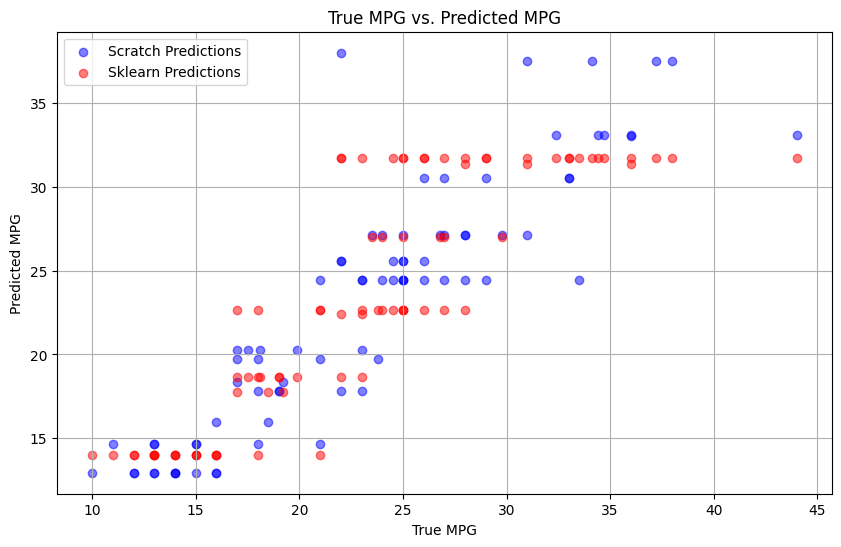

In [75]:
# "predictions" holds the y_pred values implemented from scratch
# "y_pred" holds the y_pred values from Sklearn

scratch_pred = predictions
sklearn_pred = y_pred

true_mpg = y_test
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(true_mpg, scratch_pred, label='Scratch Predictions', alpha=0.5, color='blue')
plt.scatter(true_mpg, sklearn_pred, label='Sklearn Predictions', alpha=0.5, color='red')
plt.xlabel('True MPG')
plt.ylabel('Predicted MPG')
plt.title('True MPG vs. Predicted MPG')
plt.legend()
plt.grid(True)
plt.show()

# Task - 8

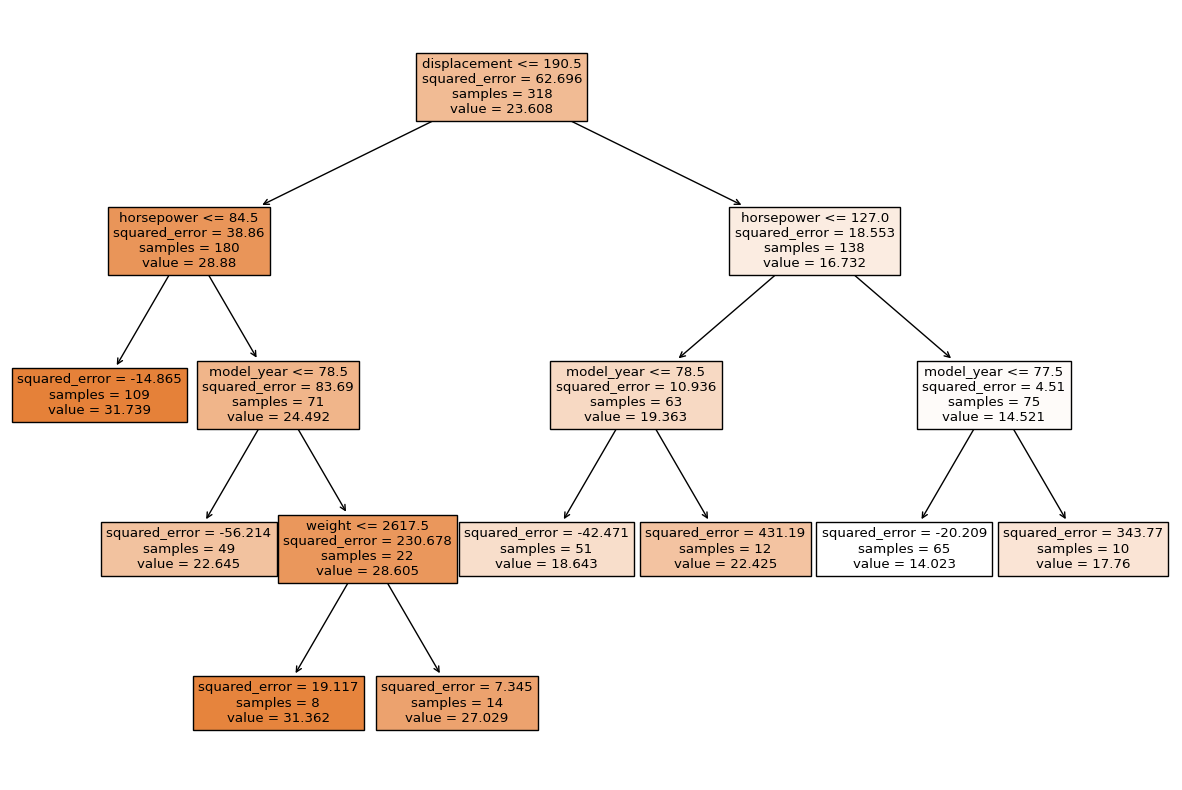

In [78]:
# visualizing decision tree using scikit-learn
from sklearn.tree import plot_tree
plt.figure(figsize=(15, 10))
plot_tree(best_tree, filled=True, feature_names=x_train.columns)
plt.show()